In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR,MultiStepLR,LambdaLR
import math
import keras
from torch.utils import data
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

torch.manual_seed(0)
def load_dataset(task='smnist'):
    if task == 'smnist':
        (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    elif task == 'psmnist':
        X_train = np.load('./ps_data/ps_X_train.npy')
        X_test = np.load('./ps_data/ps_X_test.npy')
        y_train = np.load('./ps_data/Y_train.npy')
        y_test = np.load('./ps_data/Y_test.npy')
    else:
        print('only two task, -- smnist and psmnist')
        return 0
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_train = torch.from_numpy(y_train).long()
    y_test = torch.from_numpy(y_test).long()
    train_dataset = data.TensorDataset(X_train,y_train) # create train datset
    test_dataset = data.TensorDataset(X_test,y_test) # create test datset

    return train_dataset,test_dataset

'''
STEP 3a_v2: CREATE Adaptative spike MODEL CLASS
'''
b_j0 = 0.01  # neural threshold baseline
tau_m = 20  # ms membrane potential constant
R_m = 1  # membrane resistance
dt = 1  #
gamma = .5  # gradient scale
lens = 0.5

def gaussian(x, mu=0., sigma=.5):
    return torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / torch.sqrt(2 * torch.tensor(math.pi)) / sigma


class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing ???

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # temp = abs(input) < lens
        scale = 6.0
        hight = .15
        #temp = torch.exp(-(input**2)/(2*lens**2))/torch.sqrt(2*torch.tensor(math.pi))/lens
        temp = gaussian(input, mu=0., sigma=lens) * (1. + hight) \
               - gaussian(input, mu=lens, sigma=scale * lens) * hight \
               - gaussian(input, mu=-lens, sigma=scale * lens) * hight
        # temp =  gaussian(input, mu=0., sigma=lens)
        # temp = F.relu(1-input.abs()) 93.53
        # temp = torch.exp(-5*input.abs())
        return grad_input * temp.float() * gamma


act_fun_adp = ActFun_adp.apply



def mem_update_adp(inputs, mem, spike, tau_adp,tau_m, b, dt=1, isAdapt=1):
    #     tau_adp = torch.FloatTensor([tau_adp])
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    ro = torch.exp(-1. * dt / tau_adp).cuda()
    # tau_adp is tau_adaptative which is learnable # add requiregredients
    if isAdapt:
        beta = 1.8
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * R_m * inputs - B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    # spike = F.relu(inputs_)
    return mem, spike, B, b

def output_Neuron(inputs, mem, tau_m, dt=1):
    """
    The read out neuron is leaky integrator without spike
    """
    # alpha = torch.exp(-1. * dt / torch.FloatTensor([30.])).cuda()
    alpha = torch.exp(-1. * dt / tau_m).cuda()
    mem = mem * alpha + (1. - alpha) * R_m * inputs
    return mem

'''
STEP 3b: CREATE MODEL CLASS
'''


class RNN_custom(nn.Module):
    def __init__(self, input_size, stride, hidden_dims, output_size,DC_f='mem'):
        super(RNN_custom, self).__init__()

        self.DC_f = DC_f
        self.b_j0 = b_j0
        self.stride = stride
        self.input_size = input_size
        self.output_size = output_size
        self.criterion = nn.CrossEntropyLoss()
    
        self.r1_dim = hidden_dims[0]
        self.r2_dim = hidden_dims[1]
        self.d1_dim = hidden_dims[2]
        self.i2h = nn.Linear(input_size, self.r1_dim)
        self.h2h = nn.Linear(self.r1_dim, self.r1_dim)
        self.h2d = nn.Linear(self.r1_dim, self.r2_dim)
        self.d2d = nn.Linear(self.r2_dim, self.r2_dim)
        self.dense1 = nn.Linear(self.r2_dim, self.d1_dim)
        self.d2o = nn.Linear(self.d1_dim, self.output_size)

        self.tau_adp_r1 = nn.Parameter(torch.Tensor(self.r1_dim))
        self.tau_adp_r2 = nn.Parameter(torch.Tensor(self.r2_dim))
        self.tau_adp_d1 = nn.Parameter(torch.Tensor(self.d1_dim))
        self.tau_adp_o = nn.Parameter(torch.Tensor(self.output_size))

        self.tau_m_r1 = nn.Parameter(torch.Tensor(self.r1_dim))
        self.tau_m_r2 = nn.Parameter(torch.Tensor(self.r2_dim))
        self.tau_m_d1 = nn.Parameter(torch.Tensor(self.d1_dim))
        self.tau_m_o = nn.Parameter(torch.Tensor(self.output_size))
 
        # nn.init.orthogonal_(self.h2h.weight)
        nn.init.zeros_(self.h2h.weight)
        nn.init.xavier_uniform_(self.i2h.weight)
        nn.init.xavier_uniform_(self.h2d.weight)
        # nn.init.orthogonal_(self.d2d.weight)
        nn.init.zeros_(self.d2d.weight)
        nn.init.xavier_uniform_(self.dense1.weight)
        nn.init.xavier_uniform_(self.d2o.weight)
        
        nn.init.constant_(self.i2h.bias, 0)
        nn.init.constant_(self.h2h.bias, 0)
        nn.init.constant_(self.h2d.bias, 0)
        nn.init.constant_(self.d2d.bias, 0)
        nn.init.constant_(self.dense1.bias, 0)
        nn.init.constant_(self.d2o.bias, 0)

        # nn.init.normal_(self.tau_adp_r1, 700,25)
        # nn.init.normal_(self.tau_adp_r2, 700,25)
        # nn.init.normal_(self.tau_adp_o, 700,25)
        # nn.init.normal_(self.tau_adp_d1, 700,25)
        
        nn.init.normal_(self.tau_adp_r1, 200,25)
        nn.init.normal_(self.tau_adp_r2, 200,25)
        nn.init.normal_(self.tau_adp_o, 200,25)
        nn.init.normal_(self.tau_adp_d1, 200,25)

        nn.init.normal_(self.tau_m_r1, 20,5)
        nn.init.normal_(self.tau_m_r2, 20,5)
        nn.init.normal_(self.tau_m_o, 20,5)
        nn.init.normal_(self.tau_m_d1, 20,5)

        self.b_r1 =self.b_r2 = self.b_o  = self.b_d1  = 0
    
    def compute_input_steps(self,seq_num):
        return int(seq_num/self.stride)

    def forward(self, input):
        batch_size, seq_num, input_dim = input.shape
        self.b_r1 =self.b_r2 = self.b_o  = self.b_d1  = torch.tensor(b_j0)
        
        self.initial_neuron_states(batch_size)
        
        loss = 0
        l1_spikes = []
        l2_spikes = []
        l3_spikes = []
        l4_spikes = []
        out_spikes = []
        input = input/255.
        input_steps  = self.compute_input_steps(seq_num)

        for i in range(input_steps):
            start_idx = i*self.stride
            if start_idx < (seq_num - self.input_size):
                input_x = input[:, start_idx:start_idx+self.input_size, :].reshape(-1,self.input_size)
            else:
                input_x = input[:, -self.input_size:, :].reshape(-1,self.input_size)
            #print(input_x.shape)
            h_input = self.i2h(input_x.float()) + self.h2h(self.r1_spike)
            self.r1_mem, self.r1_spike, theta_r1, self.b_r1 = mem_update_adp(h_input,self.r1_mem, self.r1_spike, self.tau_adp_r1, self.tau_m_r1,self.b_r1)

            d_input = self.h2d(self.r1_spike) + self.d2d(self.r2_spike)
            self.r2_mem, self.r2_spike, theta_r2, self.b_r2 = mem_update_adp(d_input, self.r2_mem, self.r2_spike, self.tau_adp_r2,self.tau_m_r2, self.b_r2)

            self.d1_mem, self.d1_spike, theta_d1, self.b_d1 = mem_update_adp(self.dense1(self.r2_spike), self.d1_mem, self.d1_spike, self.tau_adp_d1,self.tau_m_d1, self.b_d1)            

            o_input = self.d2o(self.d1_spike)
            if self.DC_f[:3]=='adp':
                self.d2o_mem, self.d2o_spike, theta_o, self.b_o = mem_update_adp(o_input,self.d2o_mem, self.d2o_spike, self.tau_adp_o, self.tau_m_o, self.b_o)
                
            elif self.DC_f == 'integrator':
                self.d2o_mem = output_Neuron(o_input,self.d2o_mem, self.tau_m_o)
                
            
            
            if i > 0: 
                if self.DC_f == 'adp-mem':
                    self.output_sumspike = self.output_sumspike + F.softmax(self.d2o_mem,dim=1)
                elif self.DC_f =='adp-spike':
                    self.output_sumspike = self.output_sumspike + self.d2o_spike
                elif self.DC_f =='integrator':
                    self.output_sumspike =self.output_sumspike+ F.softmax(self.d2o_mem,dim=1)


            l1_spikes.append(self.r1_spike.detach().cpu().numpy())
            l2_spikes.append(self.r2_spike.detach().cpu().numpy())
            l3_spikes.append(self.d1_spike.detach().cpu().numpy())
            l4_spikes.append(self.d2o_spike.detach().cpu().numpy())
            out_spikes.append(self.output_sumspike.detach().cpu().numpy())
        return self.output_sumspike,  [l1_spikes,l2_spikes,l3_spikes,l4_spikes,out_spikes]
    
    def initial_neuron_states(self,batch_size):
        self.r1_mem = self.r1_spike = torch.rand(batch_size, self.r1_dim).cuda()*self.b_j0
        self.r2_mem = self.r2_spike = torch.rand(batch_size, self.r2_dim).cuda()*self.b_j0
        self.d1_mem = self.d1_spike = torch.rand(batch_size, self.d1_dim).cuda()*self.b_j0
        self.d2o_mem = torch.rand(batch_size, output_dim).cuda()*self.b_j0
        self.d2o_spike = self.output_sumspike = torch.zeros(batch_size, output_dim).cuda()

In [6]:
def test(model, dataloader):
    correct = 0
    total = 0
    # Iterate through test dataset
    for images, labels in dataloader:
        images = images.view(-1, seq_dim, input_dim).to(device)

        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if torch.cuda.is_available():
            correct += (predicted.cpu() == labels.long().cpu()).sum()
        else:
            correct += (predicted == labels).sum()

    accuracy = 100. * correct.numpy() / total
    return accuracy


In [7]:
batch_size = 600
task = 'psmnist'
DC_f = 'adp-spike'

train_dataset,test_dataset = load_dataset(task)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)


input_dim = 1
input_size=4
stride = 1
hidden_dims = [64,256,256]
output_dim = 10
seq_dim = int(784 / input_dim)  # Number of steps to unroll

model = RNN_custom(input_size, stride,hidden_dims, output_dim,DC_f=DC_f)

model = torch.load('./model/model_94.73_Task-psmnist||Time-07-12-2022 14:26:15||EC_f--rbf||DC_f--adp-spike||multiinput-multi_input.pth')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
model.to(device)

device: cuda:0


RNN_custom(
  (criterion): CrossEntropyLoss()
  (i2h): Linear(in_features=4, out_features=64, bias=True)
  (h2h): Linear(in_features=64, out_features=64, bias=True)
  (h2d): Linear(in_features=64, out_features=256, bias=True)
  (d2d): Linear(in_features=256, out_features=256, bias=True)
  (dense1): Linear(in_features=256, out_features=256, bias=True)
  (d2o): Linear(in_features=256, out_features=10, bias=True)
)

In [6]:
accuracy = test(model,test_loader)
print('test Accuracy: ', accuracy)

test Accuracy:  94.54


In [7]:
i = 0
for images, labels in test_loader:
    if i == 0:
        i+=1   
        images = images.view(-1, seq_dim, input_dim).to(device)

        outputs, states = model(images)
    else:
        break

In [8]:
r1_spike_np = np.array(states[0])
r2_spike_np = np.array(states[1])
d1_spike_np = np.array(states[2])
d2_spike_np = np.array(states[3])

In [9]:
r1_spike_np.shape,r2_spike_np.shape,d1_spike_np.shape,d2_spike_np.shape

((784, 600, 64), (784, 600, 256), (784, 600, 256), (784, 600, 10))

In [10]:
b = r1_spike_np.shape[1]
spikes = np.zeros((784,b,64+256+256+10))
spikes[:,:,:64] = r1_spike_np
spikes[:,:,64:64+256]= r2_spike_np
spikes[:,:,64+256:64+256+256] = d1_spike_np
spikes[:,:,64+256+256:] = d2_spike_np

In [11]:
np.mean(r1_spike_np),np.mean(r2_spike_np),np.mean(d1_spike_np),np.mean(d2_spike_np),np.mean(spikes)

(0.11662056, 0.041681174, 0.014866212, 0.1813074, 0.040533994741241204)

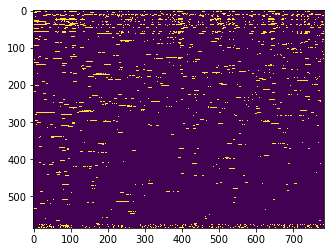

In [12]:
plt.imshow(spikes[:,1,:].T)

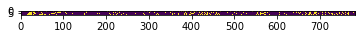

In [13]:
plt.imshow(d2_spike_np[:,1,:].T)

In [14]:
spike_count = {'total':[],'fr':[],'per step':[]}
for images, labels in test_loader: 
    images = images.view(-1, seq_dim, input_dim).to(device)
    outputs, states = model(images)

    r1_spike_np = np.array(states[0])
    r2_spike_np = np.array(states[1])
    d1_spike_np = np.array(states[2])
    d2_spike_np = np.array(states[3])
    b = r1_spike_np.shape[1]
    spikes = np.zeros((784,b,64+256+256+10))
    spikes[:,:,:64] = r1_spike_np
    spikes[:,:,64:64+256]= r2_spike_np
    spikes[:,:,64+256:64+256+256] = d1_spike_np
    spikes[:,:,64+256+256:] = d2_spike_np

    spike_count['total'].append([np.mean(np.sum(spikes,axis=(0,2))),np.max(np.sum(spikes,axis=(0,2))),np.min(np.sum(spikes,axis=(0,2)))])
    spike_count['per step'].append([np.mean(np.sum(spikes,axis=(2))),np.max(np.sum(spikes,axis=(2))),np.min(np.sum(spikes,axis=(2)))])
    spike_count['fr'].append(np.mean(spikes))

In [15]:
spike_total = np.array(spike_count['total'])
np.mean(spike_total[0]),np.max(spike_total[1]),np.min(spike_total[2])

(18595.030555555557, 19969.0, 16490.0)

In [16]:
spike_per = np.array(spike_count['per step'])
np.mean(spike_per[0]),np.max(spike_per[1]),np.min(spike_per[2])

(53.600379109977325, 136.0, 0.0)

In [17]:
spike_fr = np.array(spike_count['fr'])
np.mean(spike_fr[0])

0.04061627530705115

Text(0.5, 1.0, '$\\tau_{adp}$')

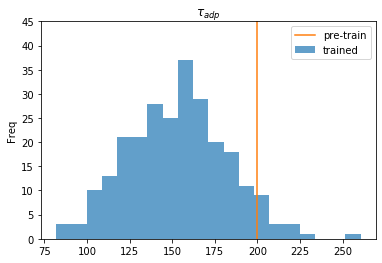

In [18]:
plt.hist(model.tau_adp_d1.detach().cpu().numpy(),bins=20,alpha=0.7,label='trained')
plt.plot([200,200],[0,50.],label='pre-train')
plt.legend()
plt.ylim([0,45])
plt.ylabel('Freq')
plt.title(r"$\tau_{adp}$")
# plt.savefig('tau_adp_d1.svg',dpi=300)

Text(0.5, 1.0, '$\\tau_{m}$')

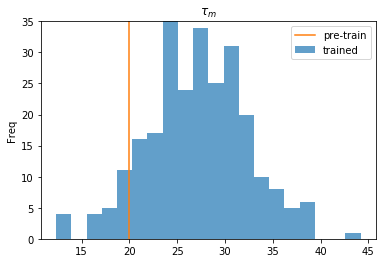

In [19]:
plt.hist(model.tau_m_d1.detach().cpu().numpy(),bins=20,alpha=0.7,label='trained')
plt.plot([20,20],[0,40],label='pre-train')
plt.legend()
plt.ylim([0,35])
plt.ylabel('Freq')
plt.title(r"$\tau_{m}$")
# plt.savefig('tau_m_d1.svg',dpi=300)

In [20]:
test_acc_classes = np.zeros((10,784))
test_acc_count = np.zeros((10,1))

for images, labels in test_loader: 
    images = images.view(-1, seq_dim, input_dim).to(device)
    outputs, states = model(images)

    output_stream = np.array(states[4])
    pred = np.argmax(output_stream,axis=2)
    labels = labels.cpu().numpy()
    b = len(labels)
    # print(b,pred.shape,labels.shape)
    labels_ = np.repeat(labels.reshape(1,b),784,axis=0)
    f_test = (pred==labels_)*1.
    # print(f_test.shape)

    for i in range(b):
        tmp = labels_[0,i]
        test_acc_classes[int(tmp),:] += f_test[:,i]
        test_acc_count[int(tmp)] += 1


In [21]:

test_s = test_acc_classes/test_acc_count


In [22]:
test_s.shape

(10, 784)

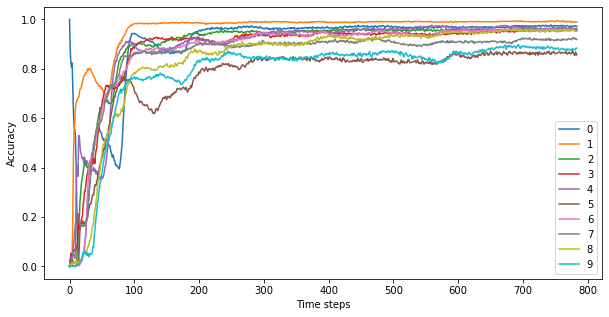

In [23]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.plot(test_s[i,:],label=str(i))
plt.ylabel('Accuracy')
plt.xlabel('Time steps')
plt.legend()
plt.savefig('psmnist_evo.svg',dpi=300)